# Synthetic sanity checks for Surprise models

This notebook runs small, controlled experiments to verify expected *ranking shifts* as we change data knobs.
We are not trying to crown a single winner, just to see the direction of change.


In [2]:
import sys
from pathlib import Path

ROOT = Path.cwd().resolve()
if (ROOT / 'src').exists():
    sys.path.insert(0, str(ROOT))
elif (ROOT.parent / 'src').exists():
    sys.path.insert(0, str(ROOT.parent))


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from surprise import Dataset, Reader, accuracy
from surprise import BaselineOnly, KNNBasic, SVD, SVDpp
from surprise.model_selection import train_test_split

from cluster_simulation import generate_mask_zipf_global, fill_ratings_clusters


In [4]:
def make_synthetic(
    U=500,
    I=800,
    density=0.05,
    alpha_user=0.9,
    alpha_item=0.9,
    seed=42,
    sigma_eps=0.4,
    sigma_bu=0.5,
    sigma_bi=0.5,
    gamma=0.4,
    beta=1.0,
    n_user_clusters=12,
    n_item_clusters=18,
):
    pairs, uc, ic, A = generate_mask_zipf_global(
        U,
        I,
        density=density,
        alpha_user=alpha_user,
        alpha_item=alpha_item,
        seed=seed,
        min_user_ratings=20,
        min_item_ratings=5,
        n_user_clusters=n_user_clusters,
        n_item_clusters=n_item_clusters,
        beta=beta,
        return_clusters=True,
    )

    R_syn = fill_ratings_clusters(
        U=U,
        I=I,
        pairs=pairs,
        user_cluster=uc,
        item_cluster=ic,
        tau=np.array([-1.2, -0.4, 0.4, 1.2]),
        seed=seed,
        mu=0,
        sigma_bu=sigma_bu,
        sigma_bi=sigma_bi,
        sigma_eps=sigma_eps,
        gamma=gamma,
        A=A,
    )

    ratings_long = pd.DataFrame(R_syn).stack().reset_index()
    ratings_long.columns = ["UserID", "MovieID", "Rating"]
    return ratings_long


def get_models():
    return {
        "BaselineOnly": BaselineOnly(verbose=False),
        "KNNBasic": KNNBasic(
            sim_options={"name": "pearson_baseline", "user_based": True},
            verbose=False,
        ),
        "SVD": SVD(random_state=42, verbose=False),
        "SVDpp": SVDpp(random_state=42, verbose=False),
    }


def eval_models(df, train_frac=0.8, seed=42):
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(df[["UserID", "MovieID", "Rating"]], reader)
    trainset, testset = train_test_split(
        data, test_size=(1 - train_frac), random_state=seed
    )

    rows = []
    for name, algo in get_models().items():
        algo.fit(trainset)
        preds = algo.test(testset)
        rmse = accuracy.rmse(preds, verbose=False)
        rows.append({"Model": name, "RMSE": float(rmse)})

    return pd.DataFrame(rows)



## 1) Learning curves (train fraction ? => test RMSE ?)
Average over 10 seeds to reduce noise.


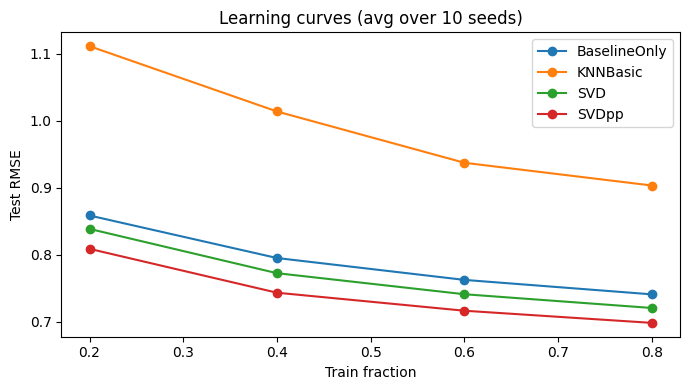

In [5]:
fractions = [0.2, 0.4, 0.6, 0.8]
seeds = list(range(10))

curve_rows = []
for frac in fractions:
    for s in seeds:
        base_df = make_synthetic(seed=s)
        res = eval_models(base_df, train_frac=frac, seed=s)
        res["TrainFrac"] = frac
        res["Seed"] = s
        curve_rows.append(res)

curve_df = pd.concat(curve_rows, ignore_index=True)
curve_mean = (
    curve_df.groupby(["Model", "TrainFrac"], as_index=False)["RMSE"]
    .mean()
)

plt.figure(figsize=(7, 4))
for model in curve_mean["Model"].unique():
    subset = curve_mean[curve_mean["Model"] == model]
    plt.plot(subset["TrainFrac"], subset["RMSE"], marker="o", label=model)
plt.title("Learning curves (avg over 10 seeds)")
plt.xlabel("Train fraction")
plt.ylabel("Test RMSE")
plt.legend()
plt.tight_layout()
plt.show()


## 2) Noise knob (sigma_eps ? => RMSE ?)


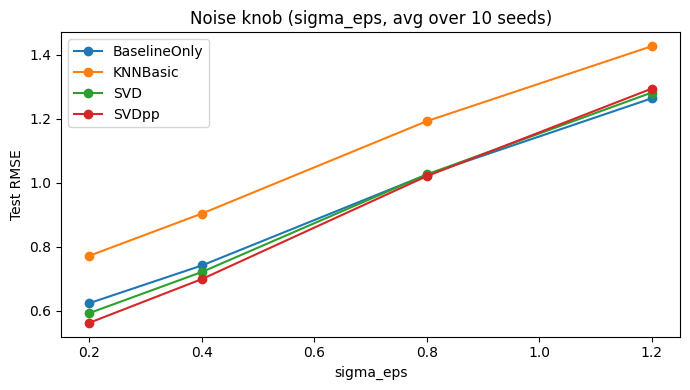

In [6]:
sigmas = [0.2, 0.4, 0.8, 1.2]
seeds = list(range(10))
rows = []
for s in sigmas:
    for seed in seeds:
        df = make_synthetic(seed=seed, sigma_eps=s)
        res = eval_models(df, train_frac=0.8, seed=seed)
        res["sigma_eps"] = s
        res["Seed"] = seed
        rows.append(res)

noise_df = pd.concat(rows, ignore_index=True)
noise_mean = (
    noise_df.groupby(["Model", "sigma_eps"], as_index=False)["RMSE"]
    .mean()
)
plt.figure(figsize=(7, 4))
for model in noise_mean["Model"].unique():
    subset = noise_mean[noise_mean["Model"] == model]
    plt.plot(subset["sigma_eps"], subset["RMSE"], marker="o", label=model)
plt.title("Noise knob (sigma_eps, avg over 10 seeds)")
plt.xlabel("sigma_eps")
plt.ylabel("Test RMSE")
plt.legend()
plt.tight_layout()
plt.show()


## 3) Sparsity knob (lower density hurts KNN more than MF)


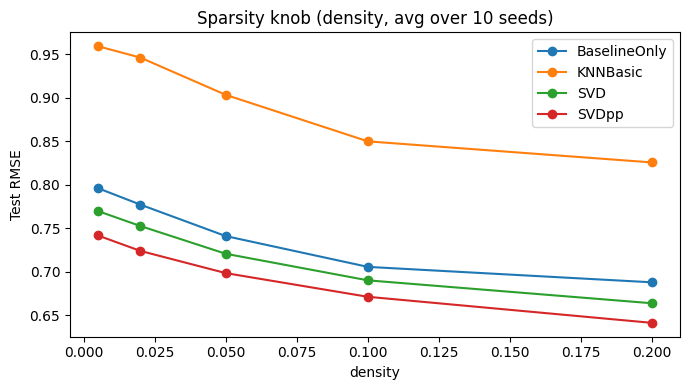

In [7]:
densities = [0.005, 0.02, 0.05, 0.1, 0.2]
seeds = list(range(10))
rows = []
for d in densities:
    for s in seeds:
        df = make_synthetic(seed=s, density=d)
        res = eval_models(df, train_frac=0.8, seed=s)
        res["density"] = d
        res["Seed"] = s
        rows.append(res)

dens_df = pd.concat(rows, ignore_index=True)
dens_mean = (
    dens_df.groupby(["Model", "density"], as_index=False)["RMSE"]
    .mean()
)
plt.figure(figsize=(7, 4))
for model in dens_mean["Model"].unique():
    subset = dens_mean[dens_mean["Model"] == model]
    plt.plot(subset["density"], subset["RMSE"], marker="o", label=model)
plt.title("Sparsity knob (density, avg over 10 seeds)")
plt.xlabel("density")
plt.ylabel("Test RMSE")
plt.legend()
plt.tight_layout()
plt.show()


## 4) Popularity knob (item bias dominates => BaselineOnly stronger)


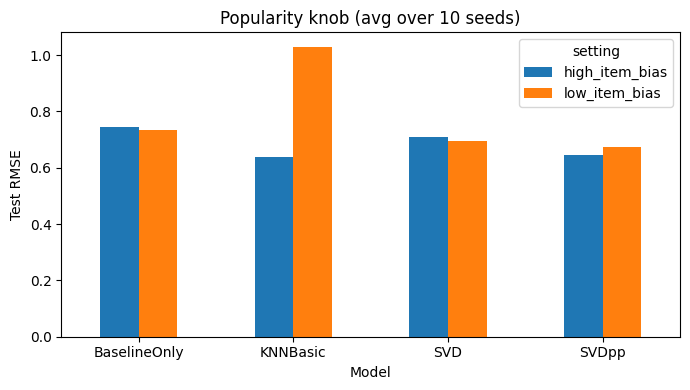

setting,high_item_bias,low_item_bias
Model,,
BaselineOnly,0.745175,0.735176
KNNBasic,0.637351,1.029665
SVD,0.709512,0.695436
SVDpp,0.645967,0.674190


In [8]:
settings = [
    {"label": "low_item_bias", "sigma_bi": 0.2, "sigma_bu": 0.8, "gamma": 0.4},
    {"label": "high_item_bias", "sigma_bi": 1.2, "sigma_bu": 0.1, "gamma": .4},
]
seeds = list(range(10))
rows = []
for cfg in settings:
    for seed in seeds:
        df = make_synthetic(
            seed=seed,
            sigma_bi=cfg["sigma_bi"],
            sigma_bu=cfg["sigma_bu"],
            gamma=cfg["gamma"],

        )
        res = eval_models(df, train_frac=0.8, seed=seed)
        res["setting"] = cfg["label"]
        res["Seed"] = seed
        rows.append(res)

pop_df = pd.concat(rows, ignore_index=True)
pop_mean = (
    pop_df.groupby(["Model", "setting"], as_index=False)["RMSE"]
    .mean()
)
pivot = pop_mean.pivot(index="Model", columns="setting", values="RMSE")
pivot.plot(kind="bar", figsize=(7, 4), rot=0, title="Popularity knob (avg over 10 seeds)")
plt.ylabel("Test RMSE")
plt.tight_layout()
plt.show()
pivot


## 6) Interaction knob (gamma ? => MF benefits more)
We vary gamma to amplify latent interactions; MF should improve relative to KNN/Baseline.


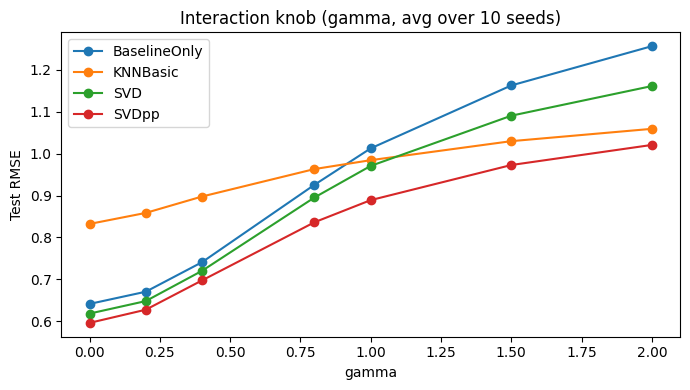

In [9]:
gammas = [0.0, 0.2, 0.4, 0.8, 1, 1.5, 2]
seeds = list(range(6))
rows = []
for g in gammas:
    for seed in seeds:
        df = make_synthetic(seed=seed, gamma=g)
        res = eval_models(df, train_frac=0.8, seed=seed)
        res["gamma"] = g
        res["Seed"] = seed
        rows.append(res)

gamma_df = pd.concat(rows, ignore_index=True)
gamma_mean = (
    gamma_df.groupby(["Model", "gamma"], as_index=False)["RMSE"]
    .mean()
)

plt.figure(figsize=(7, 4))
for model in gamma_mean["Model"].unique():
    subset = gamma_mean[gamma_mean["Model"] == model]
    plt.plot(subset["gamma"], subset["RMSE"], marker="o", label=model)
plt.title("Interaction knob (gamma, avg over 10 seeds)")
plt.xlabel("gamma")
plt.ylabel("Test RMSE")
plt.legend()
plt.tight_layout()
plt.show()
